# Create Prosumer Coalitions (N=3,5,10)

Pull in the same prosumers and generate the NRG exchange payment for the given consumption and production. The Total Consumption vs. the Total Production is plotted for each itteration to show the incremental change of the growing prosumer network. The data for each prosumer has been synthesized with the same starting values. The max and min payments prices came from the historial max and min payments from the prosumer service territory. These max and min prices where used in the NRG-X-change mechanisim to calculate the payment for the prosumers and for the consumers. The prosumers that are generating more than they consume are paid according to how much they are providing for the demand of the others on the network at that time step. The time steps are divided by months. The coalitional game is created to join the generation of more than one prosumer before getting paid by the NRG-X-Change mechanisim to improve the odds of payment.  

## Prosumers N=3

In [41]:
# Data gathering and synthesization has been done in a seperate module
import p0_data_gather as p0

# Pull data from a dataset of randomly insantiated prosumer, synthesized from EIA.gov data trends 
dem_mean = 1100
gen_mean = 1300 
prosumers_n = p0.get_data(path='data/prosumer_N10_all_20210305_1129.csv',query=f'id > 0 & id<=3 & demand_std == {dem_mean*0.20} & generation_std == {gen_mean*0.20} & generation_mean == {gen_mean} & demand_mean == {dem_mean}')

# Gather Data into Monthly Time Steps
prosumers_n_t = [pd.DataFrame(y) for x, y in prosumers_n.groupby('time', as_index=False)]

# Print Sample of Data
from IPython.display import HTML
HTML(prosumers_n_t[0].to_html(index=False))


id,time,demand,generation,consumption,net_energy,price,demand_std,generation_std,generation_mean,demand_mean
1,2019-10-01,757.174284,698.980517,58.193767,0.0,11.66,220.0,260.0,1300,1100
2,2019-10-01,1230.621807,503.603134,727.018673,0.0,11.66,220.0,260.0,1300,1100
3,2019-10-01,1241.295996,681.009070,560.286926,0.0,11.66,220.0,260.0,1300,1100


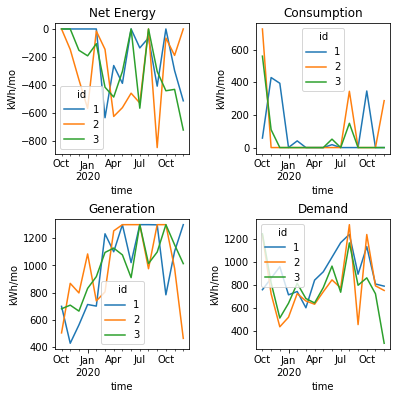

In [42]:
import numpy as np
import matplotlib.pyplot as plt
df_plt= prosumers_n
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(6, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
df_plt.pivot(index='time', columns='id', values='net_energy').plot(ax=axes[0, 0])
axes[0, 0].set_title("Net Energy")
axes[0, 0].set_ylabel("kWh/mo")
df_plt.pivot(index='time', columns='id', values='consumption').plot(ax=axes[0, 1])
axes[0, 1].set_title("Consumption")
axes[0, 1].set_ylabel("kWh/mo")
df_plt.pivot(index='time', columns='id', values='generation').plot(ax=axes[1, 0])
axes[1, 0].set_title("Generation")
axes[1, 0].set_ylabel("kWh/mo")
df_plt.pivot(index='time', columns='id', values='demand').plot(ax=axes[1, 1])
axes[1, 1].set_title("Demand")
axes[1, 1].set_ylabel("kWh/mo")
plt.show()

### Prosumer Payment Function 

The NRG-X-Change as described by the authors performs a dynamic payment to prosumers that are capable of meeting the demand of the micro-grid. The micro-grid is made of prosumers and consumers. As the load demand spikes the pricing for net generation also spikes to meet the demand. When there is too much generation on the grid the pricing drops encouraging prosumers to generate less and consumer to consume more. The payout function g(.) , utilizes a normalization component in the denominator to account for over or under generation distributing the payout along the curve. The payment is at its highest when generation meets the total demand and at its lowest as generation starts to saturate the market because of low demand. 

$$ g(x,t_p,t_c) = \frac{​​x^n* q_{t_p=t_c}​​}{e^{\frac{(t_p - t_c)^2}{a}}} $$

In [43]:
import math
# NRGXChange Payment g(.) Function
def g(price,p,tp,tc,a,n):
    x = p
    q = (0.01*price)
    try:
        #print(f"n{n},tp{tp},tc{tc},a{a},q{q}")
        pay = abs((pow(x,n)*q)/math.exp(pow((tp-tc),2)/a))
    except OverflowError:
        pay = float('inf')
    return pay

### Consumer Charge/Cost Function

Where $x$, is the net energy of the prosumer. $q$, is the maximum price allowed. $t_p$ ,is the total produced energy of all prosumers. $t_c$ is the total consumption of all the prosumers. $a$ , is a scaling constant to adjust the pay out. Similarly lets consider the cost of energy for consumers to purchase based on pricing set by the h(.) function. In tandem these incentives are non-linear because of the distribution curve. The shape of that curve can be adjusted to the size of the network and the volatility of the network.

$$ h(y,t_p,t_c) = \frac{y*r_{t_c>>t_p}​*t_c​}{t_c+t_p} $$

Where $y$ is the withdrawn energy, and $r_{t_c>>t_p}​$ is the maximum cost of energy delivered by the utility when the energy supply by prosumers is low. Again, $t_p$ is the total production and $t_c$ is the total consumption of the prosumers in the network. The minimum payment by the utility in the historical payment prices would indicate the minimum amount willing to charge customers for energy in order to cover the cost of delivering the energy. We will use the minimum price in our list for $r$.

In [44]:
# NRGXChange Charge h(.) Function
def h(price,c,tp,tc):
    y = c
    r = (0.01*price)
    try:
        cost = (y*r*tc)/(tc+tp)
    except OverflowError:
        cost = float('inf')
    return cost

### Apply Payments and Charges to Prosumers Using NRG-X-Change

The scalar for the nrg payment would need to be self-tracking. A sweep of possible a values was done to track when any of the value goes past the "inf" value.

In [45]:
import pandas as pd
#calculate the payment at time t, for all prosumers
def get_nrg_payments(df_by_t,max_price,min_price,a=0):
    if a==0:
        a = 100000 #default the a scaler
    for t in df_by_t:
        tc = t['consumption'].sum()
        tp = abs(t['net_energy']).sum()
        t['prosumer_credit'] = t['net_energy'].apply(lambda x: g(price=max_price,p=abs(x),tc=tc,tp=tp,n=1,a=a) if abs(x) > 0 else 0)
        t['prosumer_debit'] = t['consumption'].apply(lambda x: -(h(price=min_price,c=x,tc=tc,tp=tp)) if abs(x) > 0 else 0) 
        #print(f"tc={tc},tp={tp}")
        t['prosumer_revenue'] = t['prosumer_credit'] + t['prosumer_debit']
    return df_by_t

#historical pricing limits
max_price = prosumers_n['price'].max()
min_price = prosumers_n['price'].min()

# Applying payments to each record
prev_std = 0
a_scaled = 0
for a in np.arange(start=10000,stop=(10000*1000),step=10000):
    prosumers_n_t = get_nrg_payments(prosumers_n_t,max_price,min_price,a=a)
    df = pd.concat(prosumers_n_t)
    std = df['prosumer_credit'].std()
    pct_c = ((std - prev_std)/std)
    #print(pct_c)
    prev_std = std
    if  pct_c < 0.001:
        a_scaled = a
        print(f"Found significant 'a' scalar to be :{a} because of a {pct_c*100:.4f}% change in standard deviation of prosumer revenue values")
        break

# Print Sample of Data
#from IPython.display import HTML
HTML(prosumers_n_t[0].to_html(index=False))
#df = pd.concat(prosumers_n3_tier1_t)
#print(df)


Found significant 'a' scalar to be :3150000 because of a 0.0995% change in standard deviation of prosumer revenue values


id,time,demand,generation,consumption,net_energy,price,demand_std,generation_std,generation_mean,demand_mean,prosumer_credit,prosumer_debit,prosumer_revenue
1,2019-10-01,757.174284,698.980517,58.193767,0.0,11.66,220.0,260.0,1300,1100,0,-5.726267,-5.726267
2,2019-10-01,1230.621807,503.603134,727.018673,0.0,11.66,220.0,260.0,1300,1100,0,-71.538637,-71.538637
3,2019-10-01,1241.295996,681.009070,560.286926,0.0,11.66,220.0,260.0,1300,1100,0,-55.132233,-55.132233


Analyzing 3 Prosumers
An analysis of the collective positive and negative cashflow of the prosumers is shown in the following plot as color. The size of each point indicates the amount of cash and the axis represent the relationship between the total consumption of the group and the total production of the group. Each sample indicates a single point in time, where in this study it ranges for 14 consecutive months.


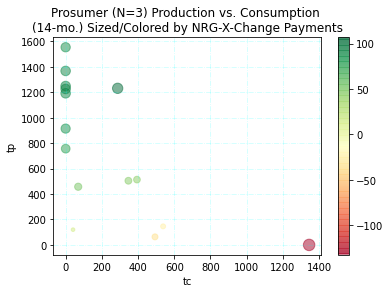

In [46]:
import matplotlib.pyplot as plt
N = len(prosumers_n_t[0])
df = pd.concat(prosumers_n_t)
df = df.groupby(['time']).sum().drop(columns=['id','price'])
df['tp'] = abs(df['net_energy'])
df['tc'] = df['consumption']
fig, ax = plt.subplots()
df.plot(kind='scatter', y='tp', x='tc',s=abs(df['prosumer_revenue']),ax=ax ,alpha=0.5, c= df['prosumer_revenue'], cmap='RdYlGn')
plt.grid(b=True, color='aqua', alpha=0.2, linestyle='dashdot')
plt.title(f"Prosumer (N={N}) Production vs. Consumption \n(14-mo.) Sized/Colored by NRG-X-Change Payments")
plt.show()


### Apply Cooperative Game Theory to Prosumers in a NRG-X-Change Market

#### Review of Game Theory and Shapley Value

The game is in terms of a **characteristic function**, which specfies for every group of players the total payoff that the members of S can by signing an greement among themselves; this payoff is available for distribution among the members of the group. A coalitional game with transferable payoff is a pair $<N,v>$ where $N=\{1,...,n\}$ is the set of players and for every subset S of I (called a coalition) $v(S) \in \mathbb{R} $ is the total payoff that is available for division among members of S (called the worth of S). We assume that the larger the coalition the larger the payoff (this property is called superadditivity).

An agreement amongst players is a list $(x_1,x_1,...,x_n)$  where $x_1,$ is the proposed payoff to individual i. Shapley value is interpreted in terms of **expected marginal contribution**. It is calculated by considering all the possible orders of arrival of the players into a room and giving each player his marginal contribution. 


In [47]:
# Shapley Value Python Logic 
# Authored by Susobhan Ghosh
# https://github.com/susobhang70
# Committed on 02/01/2020
from itertools import combinations
import bisect
#Create Combinatorial from List
def power_set(List):
    PS = [list(j) for i in range(len(List)) for j in combinations(List, i+1)]
    return PS
#Calculate Shapley from Characteristic Value list
def get_shapley(n,v):
    tempList = list([i for i in range(n)]) 
    N = power_set(tempList)
    shapley_values = []
    for i in range(n):
        shapley = 0
        for j in N:
            if i not in j:
                cmod = len(j)
                Cui = j[:]
                bisect.insort_left(Cui,i)
                l = N.index(j)
                k = N.index(Cui)
                temp = float(float(v[k]) - float(v[l])) *\
                           float(math.factorial(cmod) * math.factorial(n - cmod - 1)) / float(math.factorial(n))
                shapley += temp
        cmod = 0
        Cui = [i]
        k = N.index(Cui)
        temp = float(v[k]) * float(math.factorial(cmod) * math.factorial(n - cmod - 1)) / float(math.factorial(n))
        shapley += temp
        shapley_values.append(shapley)
    return shapley_values
   

In [48]:
for t in prosumers_n_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    n=1
    a=a_scaled
    t['nrg_v'] = t['net_energy'].apply(lambda x: g(price=max_price,p=abs(x),tc=tc,tp=tp,n=n,a=a) if abs(x) > 0 else 0) 
    
#Sample of Data
from IPython.display import HTML
HTML(prosumers_n_t[4].to_html(index=False))

id,time,demand,generation,consumption,net_energy,price,demand_std,generation_std,generation_mean,demand_mean,prosumer_credit,prosumer_debit,prosumer_revenue,nrg_v
1,2020-02-01,741.830771,700.851761,40.97901,0.000000,11.76,220.0,260.0,1300,1100,0.000000,-1.026648,-1.026648,0.000000
2,2020-02-01,723.828069,738.891573,0.00000,-15.063505,11.76,220.0,260.0,1300,1100,1.817574,0.000000,1.817574,1.817574
3,2020-02-01,812.585379,917.494903,0.00000,-104.909524,11.76,220.0,260.0,1300,1100,12.658461,0.000000,12.658461,12.658461


In [49]:
#calculate coalitional payout each time step of t
for t in prosumers_n_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    a=a_scaled
    #identify number of prosumers at every time step of t, that have provided net_energy > 0
    ids_net_energy_given = t[abs(t['net_energy']) > 0]['id']
    N_c=len(ids_net_energy_given)
    #sum the absolute value of all the net energy given by the indentified IDs
    #abs(t.loc[t['id'].isin(ids_net_energy_given)]['net_energy']).sum()
    t['coalition_v'] = 0
    if N_c == 1:
        t['coalition_v'] = t['nrg_v']
    if N_c > 1:
        List = ids_net_energy_given
        PS = [list(j) for i in range(len(List)) for j in combinations(List, i+1)]
        char_vals = []
        for n in PS:
            #locate all ids in time step within the powerset, (factorial), and sum up
            contribution = abs(t.loc[t['id'].isin(n)]['net_energy']).sum()
            char_func_val = g(price=max_price,p=contribution,tc=tc,tp=tp,n=1,a=a) 
            char_vals.append(char_func_val)
        #print(PS)
        #print(char_vals)
        shapleys = get_shapley(N_c,char_vals)
        for i in range(N_c):
            t.loc[t.index[ids_net_energy_given.values[i]-1], 'coalition_v'] = shapleys[i]

#Sample of Data
from IPython.display import HTML
HTML(prosumers_n_t[3].to_html(index=False))

result = pd.concat(prosumers_n_t)
HTML(result.to_html(index=False))

id,time,demand,generation,consumption,net_energy,price,demand_std,generation_std,generation_mean,demand_mean,prosumer_credit,prosumer_debit,prosumer_revenue,nrg_v,coalition_v
1,2019-10-01,757.174284,698.980517,58.193767,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-5.726267,-5.726267,0.000000,0.000000
2,2019-10-01,1230.621807,503.603134,727.018673,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-71.538637,-71.538637,0.000000,0.000000
3,2019-10-01,1241.295996,681.009070,560.286926,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-55.132233,-55.132233,0.000000,0.000000
1,2019-11-01,856.581711,427.340324,429.241387,0.000000,12.09,220.0,260.0,1300,1100,0.000000,-33.234636,-33.234636,0.000000,0.000000
2,2019-11-01,722.211216,868.127766,0.000000,-145.916550,12.09,220.0,260.0,1300,1100,16.798233,0.000000,16.798233,16.798233,16.798233
3,2019-11-01,817.316715,707.889217,109.427498,0.000000,12.09,220.0,260.0,1300,1100,0.000000,-8.472582,-8.472582,0.000000,0.000000
1,2019-12-01,956.424678,562.262330,394.162348,0.000000,11.62,220.0,260.0,1300,1100,0.000000,-16.841904,-16.841904,0.000000,0.000000
2,2019-12-01,436.158803,797.827130,0.000000,-361.668327,11.62,220.0,260.0,1300,1100,43.528253,0.000000,43.528253,43.528253,43.528253
3,2019-12-01,512.060530,663.954644,0.000000,-151.894114,11.62,220.0,260.0,1300,1100,18.281074,0.000000,18.281074,18.281074,18.281074
1,2020-01-01,712.969492,712.567943,0.401549,0.000000,11.72,220.0,260.0,1300,1100,0.000000,-0.000021,-0.000021,0.000000,0.000000


## Prosumers N=5

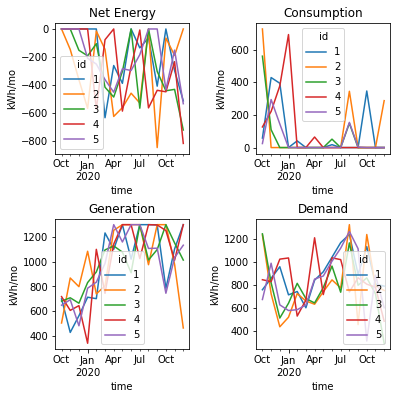

Found significant 'a' scalar to be :2090000 because of a 0.0999% change in standard deviation of prosumer revenue values


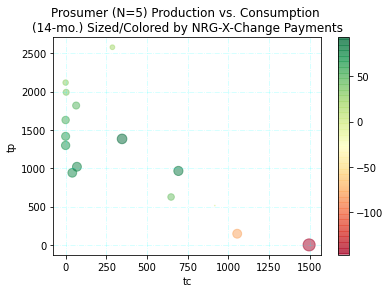

id,time,demand,generation,consumption,net_energy,price,demand_std,generation_std,generation_mean,demand_mean,prosumer_credit,prosumer_debit,prosumer_revenue,nrg_v,coalition_v
1,2019-10-01,757.174284,698.980517,58.193767,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-5.726267,-5.726267,0.000000,0.000000
2,2019-10-01,1230.621807,503.603134,727.018673,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-71.538637,-71.538637,0.000000,0.000000
3,2019-10-01,1241.295996,681.009070,560.286926,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-55.132233,-55.132233,0.000000,0.000000
4,2019-10-01,843.911097,717.432484,126.478613,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-12.445495,-12.445495,0.000000,0.000000
5,2019-10-01,672.649709,647.969906,24.679803,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-2.428493,-2.428493,0.000000,0.000000
1,2019-11-01,856.581711,427.340324,429.241387,0.000000,12.09,220.0,260.0,1300,1100,0.000000,-37.103862,-37.103862,0.000000,0.000000
2,2019-11-01,722.211216,868.127766,0.000000,-145.916550,12.09,220.0,260.0,1300,1100,11.883133,0.000000,11.883133,11.883133,11.883133
3,2019-11-01,817.316715,707.889217,109.427498,0.000000,12.09,220.0,260.0,1300,1100,0.000000,-9.458973,-9.458973,0.000000,0.000000
4,2019-11-01,827.408281,605.949567,221.458714,0.000000,12.09,220.0,260.0,1300,1100,0.000000,-19.143013,-19.143013,0.000000,0.000000
5,2019-11-01,986.823771,692.295160,294.528610,0.000000,12.09,220.0,260.0,1300,1100,0.000000,-25.459215,-25.459215,0.000000,0.000000


In [50]:
# Data gathering and synthesization has been done in a seperate module
import p0_data_gather as p0

# Pull data from a dataset of randomly insantiated prosumer, synthesized from EIA.gov data trends 
dem_mean = 1100
gen_mean = 1300 
prosumers_n = p0.get_data(path='data/prosumer_N10_all_20210305_1129.csv',query=f'id > 0 & id<=5 & demand_std == {dem_mean*0.20} & generation_std == {gen_mean*0.20} & generation_mean == {gen_mean} & demand_mean == {dem_mean}')

# Gather Data into Monthly Time Steps
prosumers_n_t = [pd.DataFrame(y) for x, y in prosumers_n.groupby('time', as_index=False)]

# Print Sample of Data
from IPython.display import HTML
HTML(prosumers_n_t[0].to_html(index=False))

import numpy as np
import matplotlib.pyplot as plt
df_plt= prosumers_n
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(6, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
df_plt.pivot(index='time', columns='id', values='net_energy').plot(ax=axes[0, 0])
axes[0, 0].set_title("Net Energy")
axes[0, 0].set_ylabel("kWh/mo")
df_plt.pivot(index='time', columns='id', values='consumption').plot(ax=axes[0, 1])
axes[0, 1].set_title("Consumption")
axes[0, 1].set_ylabel("kWh/mo")
df_plt.pivot(index='time', columns='id', values='generation').plot(ax=axes[1, 0])
axes[1, 0].set_title("Generation")
axes[1, 0].set_ylabel("kWh/mo")
df_plt.pivot(index='time', columns='id', values='demand').plot(ax=axes[1, 1])
axes[1, 1].set_title("Demand")
axes[1, 1].set_ylabel("kWh/mo")
plt.show()


#historical pricing limits
max_price = prosumers_n['price'].max()
min_price = prosumers_n['price'].min()

# Applying payments to each record
prev_std = 0
a_scaled = 0
for a in np.arange(start=10000,stop=(10000*1000),step=10000):
    prosumers_n_t = get_nrg_payments(prosumers_n_t,max_price,min_price,a=a)
    df = pd.concat(prosumers_n_t)
    std = df['prosumer_credit'].std()
    pct_c = ((std - prev_std)/std)
    #print(pct_c)
    prev_std = std
    if  pct_c < 0.001:
        a_scaled = a
        print(f"Found significant 'a' scalar to be :{a} because of a {pct_c*100:.4f}% change in standard deviation of prosumer revenue values")
        break

# Print Sample of Data
#from IPython.display import HTML
HTML(prosumers_n_t[0].to_html(index=False))
#df = pd.concat(prosumers_n3_tier1_t)
#print(df)


import matplotlib.pyplot as plt
N = len(prosumers_n_t[0])
df = pd.concat(prosumers_n_t)
df = df.groupby(['time']).sum().drop(columns=['id','price'])
df['tp'] = abs(df['net_energy'])
df['tc'] = df['consumption']
fig, ax = plt.subplots()
df.plot(kind='scatter', y='tp', x='tc',s=abs(df['prosumer_revenue']),ax=ax ,alpha=0.5, c= df['prosumer_revenue'], cmap='RdYlGn')
plt.grid(b=True, color='aqua', alpha=0.2, linestyle='dashdot')
plt.title(f"Prosumer (N={N}) Production vs. Consumption \n(14-mo.) Sized/Colored by NRG-X-Change Payments")
plt.show()


for t in prosumers_n_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    n=1
    a=a_scaled
    t['nrg_v'] = t['net_energy'].apply(lambda x: g(price=max_price,p=abs(x),tc=tc,tp=tp,n=n,a=a) if abs(x) > 0 else 0) 
    
#Sample of Data
from IPython.display import HTML
HTML(prosumers_n_t[4].to_html(index=False))

#calculate coalitional payout each time step of t
for t in prosumers_n_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    a=a_scaled
    #identify number of prosumers at every time step of t, that have provided net_energy > 0
    ids_net_energy_given = t[abs(t['net_energy']) > 0]['id']
    N_c=len(ids_net_energy_given)
    #sum the absolute value of all the net energy given by the indentified IDs
    #abs(t.loc[t['id'].isin(ids_net_energy_given)]['net_energy']).sum()
    t['coalition_v'] = 0
    if N_c == 1:
        t['coalition_v'] = t['nrg_v']
    if N_c > 1:
        List = ids_net_energy_given
        PS = [list(j) for i in range(len(List)) for j in combinations(List, i+1)]
        char_vals = []
        for n in PS:
            #locate all ids in time step within the powerset, (factorial), and sum up
            contribution = abs(t.loc[t['id'].isin(n)]['net_energy']).sum()
            char_func_val = g(price=max_price,p=contribution,tc=tc,tp=tp,n=1,a=a) 
            char_vals.append(char_func_val)
        #print(PS)
        #print(char_vals)
        shapleys = get_shapley(N_c,char_vals)
        for i in range(N_c):
            t.loc[t.index[ids_net_energy_given.values[i]-1], 'coalition_v'] = shapleys[i]

#Sample of Data
from IPython.display import HTML
HTML(prosumers_n_t[3].to_html(index=False))

result = pd.concat(prosumers_n_t)
HTML(result.to_html(index=False))

## Prosumers N=10

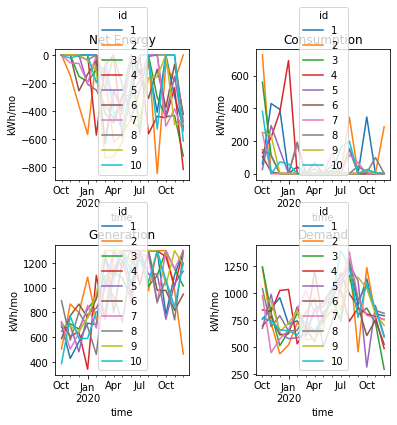

Found significant 'a' scalar to be :1510000 because of a 0.0998% change in standard deviation of prosumer revenue values


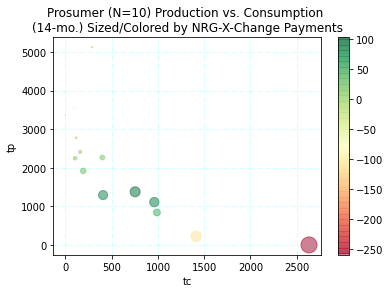

id,time,demand,generation,consumption,net_energy,price,demand_std,generation_std,generation_mean,demand_mean,prosumer_credit,prosumer_debit,prosumer_revenue,nrg_v,coalition_v
1,2019-10-01,757.174284,698.980517,58.193767,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-5.726267,-5.726267,0.000000,0.000000
2,2019-10-01,1230.621807,503.603134,727.018673,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-71.538637,-71.538637,0.000000,0.000000
3,2019-10-01,1241.295996,681.009070,560.286926,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-55.132233,-55.132233,0.000000,0.000000
4,2019-10-01,843.911097,717.432484,126.478613,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-12.445495,-12.445495,0.000000,0.000000
5,2019-10-01,672.649709,647.969906,24.679803,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-2.428493,-2.428493,0.000000,0.000000
6,2019-10-01,693.494570,588.374290,105.120280,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-10.343836,-10.343836,0.000000,0.000000
7,2019-10-01,974.670409,725.090088,249.580321,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-24.558704,-24.558704,0.000000,0.000000
8,2019-10-01,1040.271045,894.004707,146.266338,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-14.392608,-14.392608,0.000000,0.000000
9,2019-10-01,948.540002,695.130495,253.409507,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-24.935496,-24.935496,0.000000,0.000000
10,2019-10-01,766.927736,385.539889,381.387847,0.000000,11.66,220.0,260.0,1300,1100,0.000000,-37.528564,-37.528564,0.000000,0.000000


In [51]:
# Data gathering and synthesization has been done in a seperate module
import p0_data_gather as p0

# Pull data from a dataset of randomly insantiated prosumer, synthesized from EIA.gov data trends 
dem_mean = 1100
gen_mean = 1300 
prosumers_n = p0.get_data(path='data/prosumer_N10_all_20210305_1129.csv',query=f'id > 0 & id<=10 & demand_std == {dem_mean*0.20} & generation_std == {gen_mean*0.20} & generation_mean == {gen_mean} & demand_mean == {dem_mean}')

# Gather Data into Monthly Time Steps
prosumers_n_t = [pd.DataFrame(y) for x, y in prosumers_n.groupby('time', as_index=False)]

# Print Sample of Data
from IPython.display import HTML
HTML(prosumers_n_t[0].to_html(index=False))

import numpy as np
import matplotlib.pyplot as plt
df_plt= prosumers_n
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(6, 6))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
df_plt.pivot(index='time', columns='id', values='net_energy').plot(ax=axes[0, 0])
axes[0, 0].set_title("Net Energy")
axes[0, 0].set_ylabel("kWh/mo")
df_plt.pivot(index='time', columns='id', values='consumption').plot(ax=axes[0, 1])
axes[0, 1].set_title("Consumption")
axes[0, 1].set_ylabel("kWh/mo")
df_plt.pivot(index='time', columns='id', values='generation').plot(ax=axes[1, 0])
axes[1, 0].set_title("Generation")
axes[1, 0].set_ylabel("kWh/mo")
df_plt.pivot(index='time', columns='id', values='demand').plot(ax=axes[1, 1])
axes[1, 1].set_title("Demand")
axes[1, 1].set_ylabel("kWh/mo")
plt.show()


#historical pricing limits
max_price = prosumers_n['price'].max()
min_price = prosumers_n['price'].min()

# Applying payments to each record
prev_std = 0
a_scaled = 0
for a in np.arange(start=10000,stop=(10000*1000),step=10000):
    prosumers_n_t = get_nrg_payments(prosumers_n_t,max_price,min_price,a=a)
    df = pd.concat(prosumers_n_t)
    std = df['prosumer_credit'].std()
    pct_c = ((std - prev_std)/std)
    #print(pct_c)
    prev_std = std
    if  pct_c < 0.001:
        a_scaled = a
        print(f"Found significant 'a' scalar to be :{a} because of a {pct_c*100:.4f}% change in standard deviation of prosumer revenue values")
        break

# Print Sample of Data
#from IPython.display import HTML
HTML(prosumers_n_t[0].to_html(index=False))
#df = pd.concat(prosumers_n3_tier1_t)
#print(df)


import matplotlib.pyplot as plt
N = len(prosumers_n_t[0])
df = pd.concat(prosumers_n_t)
df = df.groupby(['time']).sum().drop(columns=['id','price'])
df['tp'] = abs(df['net_energy'])
df['tc'] = df['consumption']
fig, ax = plt.subplots()
df.plot(kind='scatter', y='tp', x='tc',s=abs(df['prosumer_revenue']),ax=ax ,alpha=0.5, c= df['prosumer_revenue'], cmap='RdYlGn')
plt.grid(b=True, color='aqua', alpha=0.2, linestyle='dashdot')
plt.title(f"Prosumer (N={N}) Production vs. Consumption \n(14-mo.) Sized/Colored by NRG-X-Change Payments")
plt.show()


for t in prosumers_n_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    n=1
    a=a_scaled
    t['nrg_v'] = t['net_energy'].apply(lambda x: g(price=max_price,p=abs(x),tc=tc,tp=tp,n=n,a=a) if abs(x) > 0 else 0) 
    
#Sample of Data
from IPython.display import HTML
HTML(prosumers_n_t[4].to_html(index=False))

#calculate coalitional payout each time step of t
for t in prosumers_n_t:
    tc = t['consumption'].sum()
    tp = abs(t['net_energy']).sum()
    a=a_scaled
    #identify number of prosumers at every time step of t, that have provided net_energy > 0
    ids_net_energy_given = t[abs(t['net_energy']) > 0]['id']
    N_c=len(ids_net_energy_given)
    #sum the absolute value of all the net energy given by the indentified IDs
    #abs(t.loc[t['id'].isin(ids_net_energy_given)]['net_energy']).sum()
    t['coalition_v'] = 0
    if N_c == 1:
        t['coalition_v'] = t['nrg_v']
    if N_c > 1:
        List = ids_net_energy_given
        PS = [list(j) for i in range(len(List)) for j in combinations(List, i+1)]
        char_vals = []
        for n in PS:
            #locate all ids in time step within the powerset, (factorial), and sum up
            contribution = abs(t.loc[t['id'].isin(n)]['net_energy']).sum()
            char_func_val = g(price=max_price,p=contribution,tc=tc,tp=tp,n=1,a=a) 
            char_vals.append(char_func_val)
        #print(PS)
        #print(char_vals)
        shapleys = get_shapley(N_c,char_vals)
        for i in range(N_c):
            t.loc[t.index[ids_net_energy_given.values[i]-1], 'coalition_v'] = shapleys[i]

#Sample of Data
from IPython.display import HTML
HTML(prosumers_n_t[3].to_html(index=False))

result = pd.concat(prosumers_n_t)
HTML(result.to_html(index=False))

## Conclusion
The payments for NRG before a coalition and after a colition where shown in the printed tables for N=3,5,10 prosumers. The results show that there was not a significant change between these methods that could be seen statistically. The distribution seems to already include the division of contirbution equally for each prosumer. Other methods to provide coalitional characteristic values can be explored to leverage the non-linear payment of the consumers on the network. 